In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env
from sqlalchemy import text, create_engine


In [2]:
url = env.get_db_url('logs')

In [3]:
conn = create_engine(url).connect()

In [4]:
query = text('show tables')

In [5]:
pd.read_sql(query, conn)

,Tables_in_logs
0,api_access


In [6]:
pd.read_sql('show tables', url)

,Tables_in_logs
0,api_access


In [7]:
df = pd.read_sql('select * from api_access', url)

In [8]:
df.head()

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
2,97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ...
3,97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ...
4,97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ...


In [9]:
parts = df.entry[0].split()

In [10]:
pd.set_option('display.max_columns', None)
df.entry.str.split(expand=True).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,97.105.19.58,-,-,[16/Apr/2019:19:34:42,+0000],"""GET",/api/v1/sales?page=81,"HTTP/1.1""",200,512495,"""-""","""python-requests/2.21.0""",None,None,None,None,None,None,None,None,None,None,None,None
1,97.105.19.58,-,-,[16/Apr/2019:19:34:42,+0000],"""GET",/api/v1/items,"HTTP/1.1""",200,3561,"""-""","""python-requests/2.21.0""",None,None,None,None,None,None,None,None,None,None,None,None
2,97.105.19.58,-,-,[16/Apr/2019:19:34:44,+0000],"""GET",/api/v1/sales?page=82,"HTTP/1.1""",200,510103,"""-""","""python-requests/2.21.0""",None,None,None,None,None,None,None,None,None,None,None,None
3,97.105.19.58,-,-,[16/Apr/2019:19:34:46,+0000],"""GET",/api/v1/sales?page=83,"HTTP/1.1""",200,510003,"""-""","""python-requests/2.21.0""",None,None,None,None,None,None,None,None,None,None,None,None
4,97.105.19.58,-,-,[16/Apr/2019:19:34:48,+0000],"""GET",/api/v1/sales?page=84,"HTTP/1.1""",200,511963,"""-""","""python-requests/2.21.0""",None,None,None,None,None,None,None,None,None,None,None,None


In [11]:
output = {}

In [12]:
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).strip('"')
    return pd.Series(output)

In [13]:
df = df.entry.apply(parse_log_entry)

In [20]:
df.columns

Index(['ip', 'timestamp', 'request_method', 'request_path', 'http_version',
       'status_code', 'size', 'user_agent'],
      dtype='object')

In [22]:
df['size_mb'] = df['size'] / 1024 / 1024

In [23]:
df.ip.value_counts()

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
68.201.219.223       21
70.121.214.34         2
52.87.230.102         2
35.175.171.137        2
54.145.52.184         1
3.92.201.136          1
35.174.209.2          1
34.229.70.250         1
54.172.14.223         1
34.207.64.242         1
3.88.129.158          1
52.91.30.150          1
52.90.165.200         1
45.23.250.16          1
Name: ip, dtype: int64

In [24]:
ip_df1 = df.ip.value_counts().reset_index().rename(columns={'index':'ip','ip':'cnt'})
ip_df1

,ip,cnt
0,97.105.19.58,11998
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,24.26.242.9,21
5,68.201.219.223,21
6,70.121.214.34,2
7,52.87.230.102,2
8,35.175.171.137,2
9,54.145.52.184,1


In [27]:
ip_df2 = df.ip.value_counts(normalize=True).reset_index().rename(columns={'index': 'ip', 'ip': 'percent'})
ip_df2.head()

,ip,percent
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,24.26.242.9,0.001503


In [25]:
df.ip.value_counts() / len(df)

97.105.19.58      0.858595
173.173.113.51    0.075784
72.181.113.170    0.043867
72.181.105.81     0.017604
24.26.242.9       0.001503
68.201.219.223    0.001503
70.121.214.34     0.000143
52.87.230.102     0.000143
35.175.171.137    0.000143
54.145.52.184     0.000072
3.92.201.136      0.000072
35.174.209.2      0.000072
34.229.70.250     0.000072
54.172.14.223     0.000072
34.207.64.242     0.000072
3.88.129.158      0.000072
52.91.30.150      0.000072
52.90.165.200     0.000072
45.23.250.16      0.000072
Name: ip, dtype: float64

In [29]:
ip_df = pd.merge(ip_df1, ip_df2, how='inner', on='ip')
ip_df.head()

,ip,cnt,percent
0,97.105.19.58,11998,0.858595
1,173.173.113.51,1059,0.075784
2,72.181.113.170,613,0.043867
3,72.181.105.81,246,0.017604
4,24.26.242.9,21,0.001503


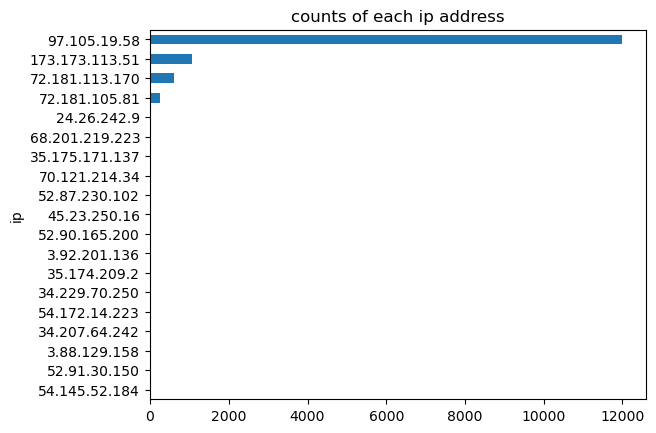

In [30]:
ip_df.set_index('ip').cnt.sort_values().plot.barh()
plt.title('counts of each ip address')
plt.show()

In [31]:
p_a_and_b = df.groupby(['ip', 'status_code']).size() / len(df)
p_a_and_b

ip              status_code
173.173.113.51  200            0.075784
24.26.242.9     200            0.001503
3.88.129.158    200            0.000072
3.92.201.136    200            0.000072
34.207.64.242   200            0.000072
34.229.70.250   200            0.000072
35.174.209.2    200            0.000072
35.175.171.137  200            0.000143
45.23.250.16    200            0.000072
52.87.230.102   200            0.000143
52.90.165.200   200            0.000072
52.91.30.150    200            0.000072
54.145.52.184   200            0.000072
54.172.14.223   200            0.000072
68.201.219.223  200            0.001503
70.121.214.34   200            0.000143
72.181.105.81   200            0.017604
72.181.113.170  200            0.043724
                499            0.000143
97.105.19.58    200            0.857593
                499            0.001002
dtype: float64

In [39]:
p_b = df.groupby('ip').size() / len(df)

In [40]:
p_a_and_b / p_b

ip              status_code
173.173.113.51  200            1.000000
24.26.242.9     200            1.000000
3.88.129.158    200            1.000000
3.92.201.136    200            1.000000
34.207.64.242   200            1.000000
34.229.70.250   200            1.000000
35.174.209.2    200            1.000000
35.175.171.137  200            1.000000
45.23.250.16    200            1.000000
52.87.230.102   200            1.000000
52.90.165.200   200            1.000000
52.91.30.150    200            1.000000
54.145.52.184   200            1.000000
54.172.14.223   200            1.000000
68.201.219.223  200            1.000000
70.121.214.34   200            1.000000
72.181.105.81   200            1.000000
72.181.113.170  200            0.996737
                499            0.003263
97.105.19.58    200            0.998833
                499            0.001167
dtype: float64

In [41]:
status_given_ip = df.groupby('ip').status_code.value_counts(normalize=True).rename('prob').reset_index()
status_given_ip

,ip,status_code,prob
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [14]:
#probability of y given x

In [15]:
#probability of y given x

In [16]:
#probability of y given x

In [17]:
#probability of y given x

In [18]:
#probability of y given x

In [19]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()


,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0
